In [570]:
using JuMP, Gurobi

    dims = 3
    k = 4              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(dims,k)    # vector of waypoint locations

    T[1] = 1
    T[2] = 20
    T[3] = 50
    T[4] = 60

    # define waypoints
    xw = [ 1   4   6   1
           1   3   0   1 
           1   2   2   1 ]
    # define waypoints
    xwTheta = [ 0   0   0   0
                0   0   0   0 
                0   0.1   0.2   0.3 ];

In [571]:
mass = 0.468
# lift constant
K = 2.980*10.0^-6
# drag constant
b = 1.140*10.0^-7
l=1
g = [0 0 -9.8]'

# Quadcopter Inertia
Ixx = 4.856*10.0^-3
Iyy = 4.856*10.0^-3
Izz = 4.856*10.0^-3;

In [572]:
    m = Model(solver = GurobiSolver(OutputFlag=0))
    
    @variable(m, x[1:dims,1:T[k]])       # resulting position
    @variable(m, theta[1:dims, 1:T[k]])  # resulting attitude
    
    @variable(m, v[1:dims,1:T[k]])       # resulting velocity
    
    # angular acceleration in the body frame
    @variable(m, AAb[1:dims, 1:T[k]])
    
    # angular velocities in the body frame
    @variable(m, AVb[1:dims, 1:T[k]])
    @expression(m, p[i=1:T[k]], AVb[1,i])
    @expression(m, q[i=1:T[k]], AVb[2,i])
    @expression(m, r[i=1:T[k]], AVb[3,i])
    
    @variable(m, u[1:2,1:T[k]])          # thruster input x-y

    # Angular velocity of rotor
    @variable(m, 0.0 <= ωSq[1:4, 1:T[k]] <= 1000000)

    # Rotor force generated in quad's frame of reference
    @expression(m, uz[i=1:4,j=1:T[k]], K*ωSq[i,j]/mass)

    # Thrust in body's frame of reference
    @expression(m, TB3[i=1:T[k]], sum(uz[j,i] for j in 1:4)*mass)

    # Rotor force generated in quad's frame of reference
    @expression(m, τM[j=1:4,i=1:T[k]], b*ωSq[j,i])

    # Torque in body's frame of reference
    @expression(m, τbϕ[i=1:T[k]] , l*K*(-ωSq[2,i] + ωSq[4,i]))
    @expression(m, τbθ[i=1:T[k]] , l*K*(-ωSq[1,i] + ωSq[3,i]))
    @expression(m, τbψ[i=1:T[k]] , sum(τM[j,i] for j in 1:4))

    for t in 1:T[k]
        @constraint(m, AAb[1,t] == (Iyy - Izz)*q[t]*r[t]/Ixx + τbϕ[t]/Ixx)
        @constraint(m, AAb[2,t] == (Izz - Ixx)*p[t]*r[t]/Iyy + τbθ[t]/Iyy)
        @constraint(m, AAb[3,t] == (Ixx - Iyy)*p[t]*q[t]/Izz + τbψ[t]/Izz)
    end

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== zeros(dims,1)')
    @constraint(m, AVb[:,1] .== zeros(dims,1)')

    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[1:2,t+1] .== v[1:2,t] + u[:,t])
        @constraint(m, v[3,t+1] == v[3,t] + uz[1,t] + uz[2,t] + uz[3,t] + uz[4,t] + g[3])
                            
        @constraint(m, theta[:,t+1] .== theta[:,t] + AVb[:,t])
        @constraint(m, AVb[1:3,t+1] .== AVb[1:3,t] + AAb[:,t])
    end

    # hit all the waypoints
    for i in [1 k]
        @constraint(m, x[:,T[i]] .== xw[:,i])
        #@constraint(m, theta[3,T[i]] == xwTheta[3,i])
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    λ = 100
    @objective(m, Min, sum(uz.^2) + sum(u.^2) + λ*sum( (x[:,T[2:k]]-xw[:,2:k]).^2  )) #+ 
                           # λ*sum( (theta[3,T[2:k]]-xwTheta[3,2:k]).^2  ))
    solve(m)

:Optimal

In [573]:
xopt = getvalue(x)

3×60 Array{Float64,2}:
 1.0  1.0  1.02433  1.0718   1.14121  1.23136  …   2.13907    1.57171   1.0
 1.0  1.0  1.02919  1.08448  1.16279  1.26102      0.720522   0.859019  1.0
 1.0  1.0  1.22777  1.64401  2.20935  2.88472     43.8135    26.7475    1.0

In [574]:
uopt = getvalue(u)

2×60 Array{Float64,2}:
 0.0243338  0.0231355  0.0219373  0.0207391  …  -0.0043463   -0.0  -0.0
 0.0291896  0.0261024  0.0230153  0.0199281      0.00248394  -0.0  -0.0

In [575]:
uoptZ = getvalue(uz)

4×60 Array{Float64,2}:
 2.50694  2.49712  2.48727  2.47751  …  0.27961  0.00459704  0.00459704
 2.50694  2.49712  2.48727  2.47751     0.27961  0.00459704  0.00459704
 2.50694  2.49712  2.48727  2.47751     0.27961  0.00459704  0.00459704
 2.50694  2.49712  2.48727  2.47751     0.27961  0.00459704  0.00459704

In [576]:
ωopt = getvalue(ωSq)

4×60 Array{Float64,2}:
 3.93708e5  3.92164e5  390619.0  …  87839.2  43911.8  721.951  721.951
 3.93708e5  3.92164e5  390619.0     87839.2  43911.8  721.951  721.951
 3.93708e5  3.92164e5  390619.0     87839.2  43911.8  721.951  721.951
 3.93708e5  3.92164e5  390619.0     87839.2  43911.8  721.951  721.951

In [577]:
thetaOpt = getvalue(theta)

3×60 Array{Float64,2}:
     -2.84135e-11      -2.84135e-11  …     -1.49973e-12  0.0
      2.31968e-10       2.31968e-10         5.99995e-12  0.0
 -61820.4          -61820.4             -2000.68         0.0

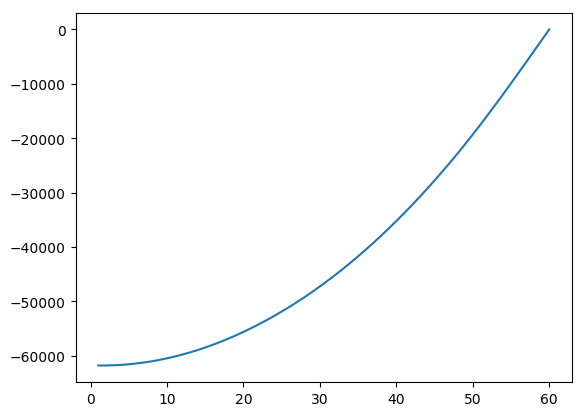

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x323b4e350>

In [578]:
using PyPlot
plot(linspace(1,T[k],T[k]), thetaOpt[3,:])

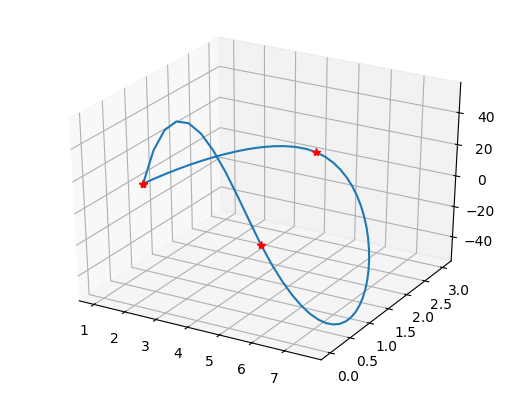

In [579]:

plot3D(xopt[1,:],xopt[2,:],xopt[3,:])
plot3D(xw[1,:],xw[2,:],xw[3,:],"r*");